# Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

Install tensorflow in your conda environment. Note that you need to have numpy-1.23.1. When I did this, I had to manually uninstall numpy-1.24.3 then install numpy-1.23.1, before installing tensorflow. The tensorflow install failed to install numpy-1.23.1, itself, even though it told me it was successful.

In [25]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import random

In [26]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sn

In [27]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

import matplotlib as mpl
import matplotlib.patches as patches

In [28]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast

# Load data from Parquet file and convert to strings
data_path = '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [29]:
def normalise_array(arr):
    min_val = ak.min(arr, axis=-1)
    max_val = ak.max(arr, axis=-1)
    return (arr - min_val) / (max_val - min_val)

# Apply normalization to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

# Print or inspect the results
print(normalised_times)
print(normalised_samples)



[[0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.997, 0.998, 0.999, 1], ...]
[[0.00238, 0.00212, 0.00198, 0.00223, ..., 0.00251, 0.00211, 0.00133, 0], ...]


# Padding the Data

In [30]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))



print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))


times_lengths = ak.num(normalised_times, axis=1)
max_time_length = ak.max(times_lengths)
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))

print(f"Length After Padding: {len(padded_times[0])}")
    

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


Now lets pad the Sample data

In [31]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(normalised_samples[0])}")
print("Structure of 'times':", ak.type(arr['samples']))


samples_lengths = ak.num(normalised_samples, axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


# Creating the Training and Test Data (AwkwardArrays)

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate times and samples as individual arrays

X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

X_combined = np.concatenate([padded_times, padded_samples], axis=1)
print(X_combined)


# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Verify the shapes of the resulting sets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

[[0.         0.00090909 0.00181818 ... 0.         0.         0.        ]
 [0.         0.00107411 0.00214823 ... 0.         0.         0.        ]
 [0.         0.0019084  0.00381679 ... 0.         0.         0.        ]
 ...
 [0.         0.00119474 0.00238949 ... 0.         0.         0.        ]
 [0.         0.00136799 0.00273598 ... 0.         0.         0.        ]
 [0.         0.00108225 0.0021645  ... 0.         0.         0.        ]]
Training data shape: (5836, 3656)
Test data shape: (1946, 3656)


# Plotting the S2 Area Spectrum

305.75293803418805
305.75293803418805 305.6645299145299 305.0864049145299
 Total Number of Training Examples 7782
1711
1189
4882
7782


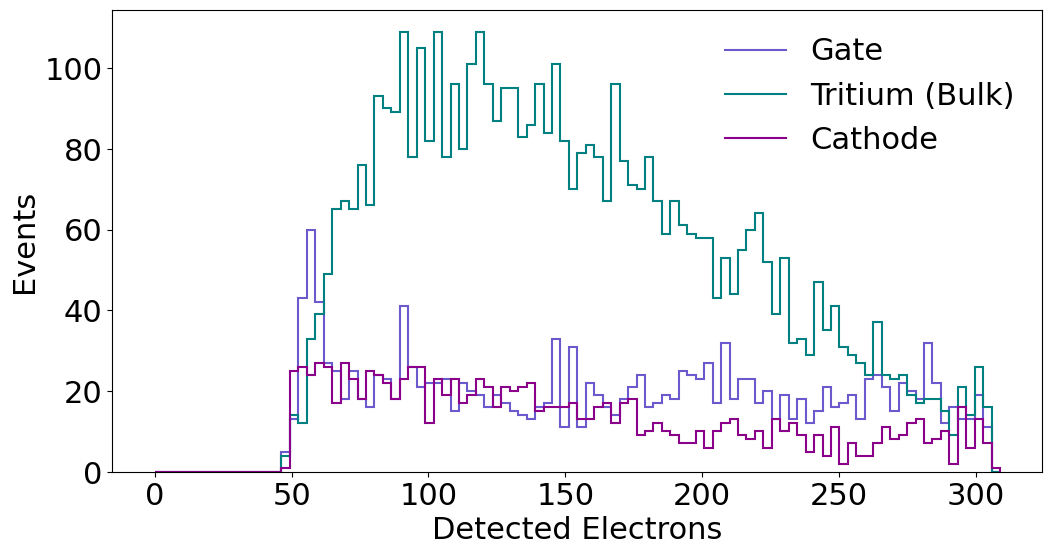

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   4.  14.  12.  33.  39.  49.  65.  67.  65.  76.  66.  93.  90.
  89. 109.  78. 105.  82. 109.  78.  96.  80. 101. 109.  96.  87.  95.
  95.  83.  86.  96.  84. 101.  82.  70.  79.  81.  78.  67.  96.  77.
  71.  70.  78.  67.  59.  67.  61.  59.  58.  58.  43.  53.  44.  55.
  60.  64.  52.  39.  53.  32.  33.  29.  47.  35.  41.  31.  29.  27.
  24.  37.  24.  23.  24.  19.  17.  18.  18.  15.   9.  21.  14.  26.
  16.   0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5. 13. 43.
 60. 42. 27. 25. 18. 25. 18. 16. 24. 23. 18. 41. 26. 21. 22. 22. 23. 15.
 22. 20. 19. 16. 19. 17. 15. 14. 13. 16. 17. 33. 11. 31. 11. 22. 19. 16.
 14. 18. 21. 24. 16. 17. 19. 18. 25. 24. 23. 27. 17. 32. 18. 23. 23. 17.
 20. 13. 19. 13. 18. 12. 15. 21. 16. 17. 19. 13. 23. 24. 21. 15. 22. 20.
 18. 32. 22. 12. 16. 13. 13. 19. 11.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 25. 26.
 24. 27. 26

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

print(max(cathode_events), max(tritium_events), max(gate_events))

print(f' Total Number of Training Examples {len(arr["label"])}')
a = len(gate_events)
b = len(cathode_events)
c = len(tritium_events)

print(a)
print(b)
print(c)
print(a+b+c)


gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
gate_hist.fill(gate_events)
gate_hist.plot(color='slateblue',density=False,yerr=False,label='Gate')

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
tritium_hist.fill(tritium_events)
tritium_hist.plot(color='teal',density=False,yerr=False,label='Tritium (Bulk)')

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01))
cathode_hist.fill(cathode_events)
cathode_hist.plot(color='darkmagenta',density=False,yerr=False,label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/Pulse_Spectrum.png', dpi=1800)
plt.show()

print(tritium_hist.view())
print(gate_hist.view())
print(cathode_hist.view())

305.7223627403846
1189.0
0.0
0.0
0.0032545047259652992


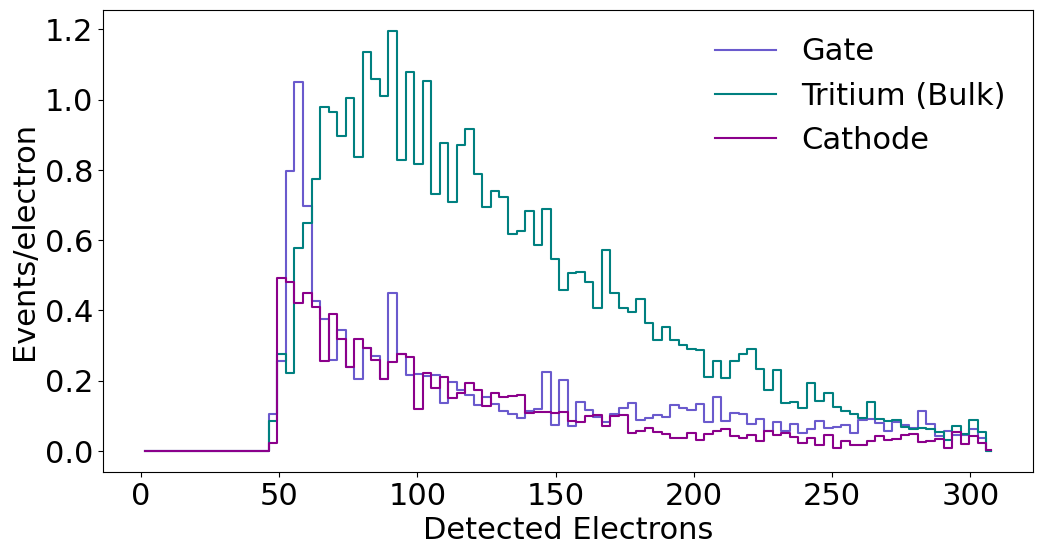

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
print(bin_edges[-2])

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers


print(cathode_hist.view().sum())
print(tritium_counts[-1])
print(gate_counts[-1])
print(cathode_counts[-1])


ax.step(bin_centers, gate_counts, where='mid', color='slateblue', label='Gate')
ax.step(bin_centers, tritium_counts, where='mid', color='teal', label='Tritium (Bulk)')
ax.step(bin_centers, cathode_counts, where='mid', color='darkmagenta', label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/eventsperelectron.png', dpi=1800)
plt.show()

# Weighting the S2 Area Spectrum

MAXareas: tritum,gate, cathode, overall dataset (17881.375, 17847.5546875, 17886.546875, 17886.546875)
0.0
0.0
0.0032545047259652992
13.411785247523326
37.54691093085141
10.274164346048565
0
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.411785

/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_56097/3717098816.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_56097/3717098816.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_56097/3717098816.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_56097/3717098816.py:75: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipyke

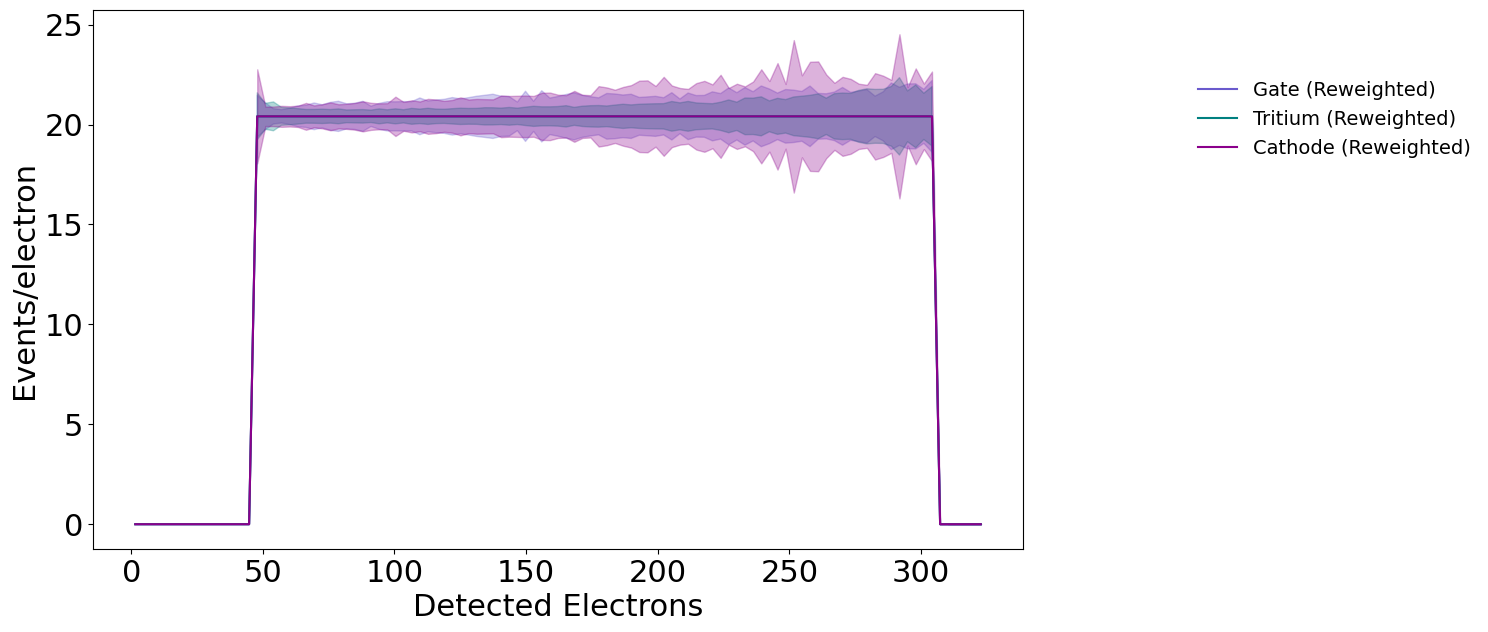

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

### CODE TO DELETE: HERE FOR TESTING PURPOSES ONLY ###

areas = arr['area']

max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'MAXareas: tritum,gate, cathode, overall dataset {max_tritium_area, max_gate_area, max_cathode_area, max_area}')

gate_counts = gate_hist.view() / bin_centers #this is the y - axis data converted to events/electron
print(gate_counts[-1])
print(tritium_counts[-1])
print(cathode_counts[-1])

### 

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 


print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()])

#for datapoint in range(0, len(gate_data)):
    #print(gate_data[datapoint])

#gate_reweighted = np.array([
    #gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0
    #for datapoint in range(len(gate_counts))
#])

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))


tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] > cathode_counts[-1] else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)

print(cathode_weights[-1])
    

#tritium_reweighted[-1] = 37.92238004
cathode_reweighted = np.array(cathode_reweighted)

print(gate_reweighted)

# print(gate_reweighted)
# print(tritium_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /60 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/60 # * (average_counts / cathode_counts.sum())

# Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Plot reweighted data with translucent error bands
# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='slateblue', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='slateblue', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='teal', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='teal', alpha=0.3
)

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='darkmagenta', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='darkmagenta', alpha=0.3
)

#ax.step(bin_centers, gate_reweighted * (average_counts/ gate_counts.sum()), where='mid', color='slateblue', label='Gate (Reweighted)')
#ax.step(bin_centers, tritium_reweighted * (average_counts/ tritium_counts.sum()), where='mid', color='teal', label='Tritium (Bulk, Reweighted)')
#ax.step(bin_centers, cathode_reweighted * (average_counts/ cathode_counts.sum()), where='mid', color='darkmagenta', label='Cathode (Reweighted)')


ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.5,0.9),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [36]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights)

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)


#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')


#print(gate_data)
#print(gate_weights)

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))


#arr['weight'] = all_weights #the final line to add all weights for each subdataset (gate, cathode and tritium) to main awkward data frame. then can feed into CNN easy.


these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [37]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Optional Code: Normalising the Weights Array

In [38]:
total_weight = ak.sum(arr['weights'])

# Normalize the weights by dividing each element by the total weight
normalized_weights = arr['weights'] / total_weight

# If you want to save the normalized weights back to the array. In Awkward, this is done by duplicating the original array and adding a new column.
arr = ak.with_field(arr, normalized_weights, 'weights_normalized')

print(arr['weights_normalized'])

[0.000543, 2.31e-05, 0.000142, 0.000142, ..., 0.000788, 0.000788, 0.000788]


# Convolutional Neural Network

Convolutional layers should improve the accuracy further but will even longer to run. You should try to understand what filters, pooling, and kernal size are. These are the hyperparameters you need to mess around with, as well as the number of convolutional layers. The filters will be used to look for certain features of the S2 waveforms so I think the kernal size should be decided based on the size of features you are trying to select. Here is a descriptive link: https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=A%20convolutional%20neural%20network%20is,classify%20objects%20in%20an%20image. This made my computer start to overheat, hence the desire to use a gpu, but maybe we are okay.

In [39]:
seed_value = 42 # set a global random seed for model reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=28, kernel_size=3, activation='relu', input_shape=(3656, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 28 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2,2) specifies a pooling window which means the layer will take the max value from every 2*2 region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons
#10 layer is our 10 neuron layer that provides a class (digit 0-1)

In [40]:
convoNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [41]:
weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalized'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalized_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']
# Assuming you already have 'X_combined' and 'labels' prepared
# Split the data (include 'area' normalization within the split for alignment)


# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test = train_test_split(
    X_combined, labels, normalized_area, weights_np, test_size=0.25, random_state=42
)

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test) # //
print("Shape of y_train:", y_train.shape)



convoNN.fit(X_train, y_train, sample_weight=weights_train, epochs=5) 

7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 3656)
Shape of y_train: (5836,)
Epoch 1/5
183/183 [==============================] - 16s 86ms/step - loss: 48.8193 - accuracy: 0.8280
Epoch 2/5
131/183 [====================>.........] - ETA: 4s - loss: 43.8406 - accuracy: 0.8516

KeyboardInterrupt: 

In [ ]:
X_test_reshaped = X_test.reshape(-1, 3656, 1)
print(X_test_reshaped.shape)
convoNN.evaluate(X_test_reshaped, y_test)

(1946, 3656, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8352 - loss: 0.3827


[0.3600314259529114, 0.839157223701477]

# Visualising the Model Classification Effectiveness: The Probability Distribution

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
True label: 2, Predicted class: 2
True label: 1, Predicted class: 1
True label: 0, Predicted class: 2
True label: 0, Predicted class: 0
True label: 0, Predicted class: 0
True label: 2, Predicted class: 2
True label: 0, Predicted class: 0
True label: 1, Predicted class: 1
True label: 0, Predicted class: 0
True label: 1, Predicted class: 1
True label: 2, Predicted class: 0
True label: 2, Predicted class: 2
True label: 2, Predicted class: 0
True label: 2, Predicted class: 0
True label: 2, Predicted class: 0
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 0, Predicted class: 0
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 2, Predicted class: 2
True label: 1, Predicted class: 1
True label: 1, Predicted class: 1
True label: 2, Predicted class: 0
True label: 0, Predicted class: 0
True label: 2, Predicted class: 2
True lab

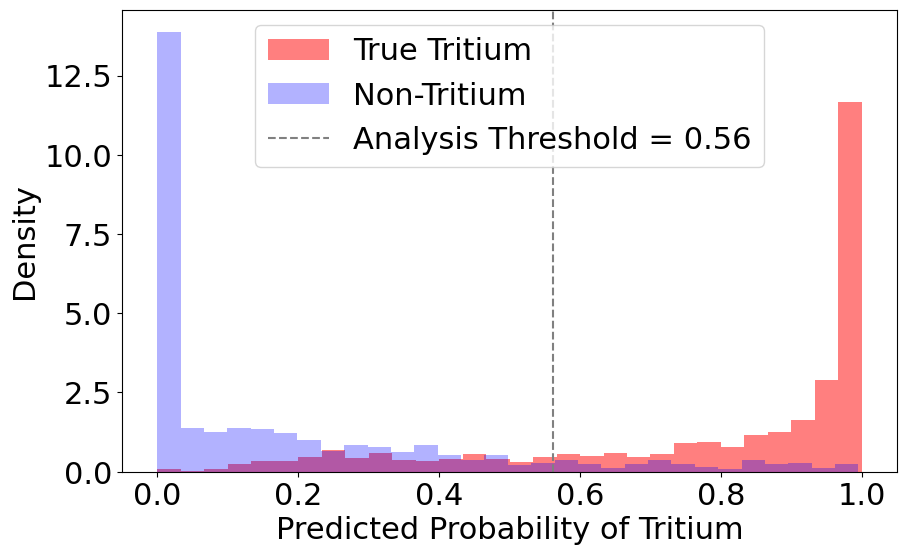

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Step 1: Get predicted probabilities for each class
y_pred_proba = convoNN.predict(X_test)

predicted_classes = np.argmax(y_pred_proba, axis=1) # axis = 1 signifies that argmax should parse through the columns of each row and find the max. value
for i in range(30):
    print(f"True label: {y_test[i]}, Predicted class: {predicted_classes[i]}")  # Initial checking to see how well the model predicts the classes for first 30 training examples 

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities. All the training examples in the training dataset that the model has predicted to be tritium.

'''
# Step 3: Plot the histograms for background and bulk probabilities
plt.figure(figsize=(10, 6))

# Background probability histogram
plt.hist(background_proba, bins=30, alpha=0.5, color='blue', label='Background (Gate + Cathode)', density=True)

# Bulk (Tritium) probability histogram
plt.hist(bulk_proba, bins=30, alpha=0.3, color='red', label='Bulk (Tritium)', density=True)

# Add titles and labels
# plt.title('Probability Histogram for Background vs Bulk Classification')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()

plt.show()

'''
# Separate true Tritium events from non-Tritium events in y_test
true_tritium_mask = (y_test == 2) # actual tritium events
non_tritium_mask = (y_test != 2) # non-tritium(background) events

threshold = np.percentile(bulk_proba[true_tritium_mask], 20)

# Step 3: Plot histograms for both groups
plt.figure(figsize=(10, 6))

# Histogram for actual Bulk (Tritium) events
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.5, color='red', label='True Tritium', density=True)

# Histogram for non-Bulk (Tritium) events
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.3, color='blue', label='Non-Tritium', density=True)

# Add titles and labels
# plt.title('Predicted Probability Histogram for Tritium Classification')
plt.axvline(x=threshold, color='gray', linestyle='--', label=f'Analysis Threshold = {threshold:.2f}')
plt.xlabel('Predicted Probability of Tritium')
plt.ylabel('Density')
plt.legend(loc='upper center')

plt.show()


# Creating the ROC Curves

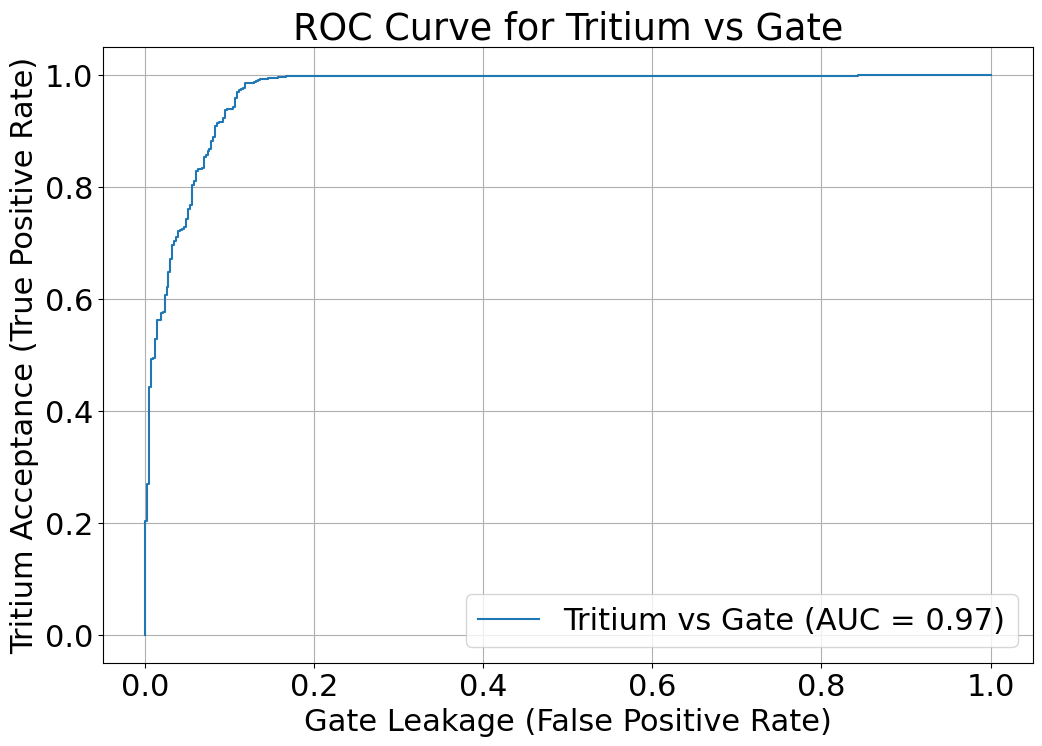

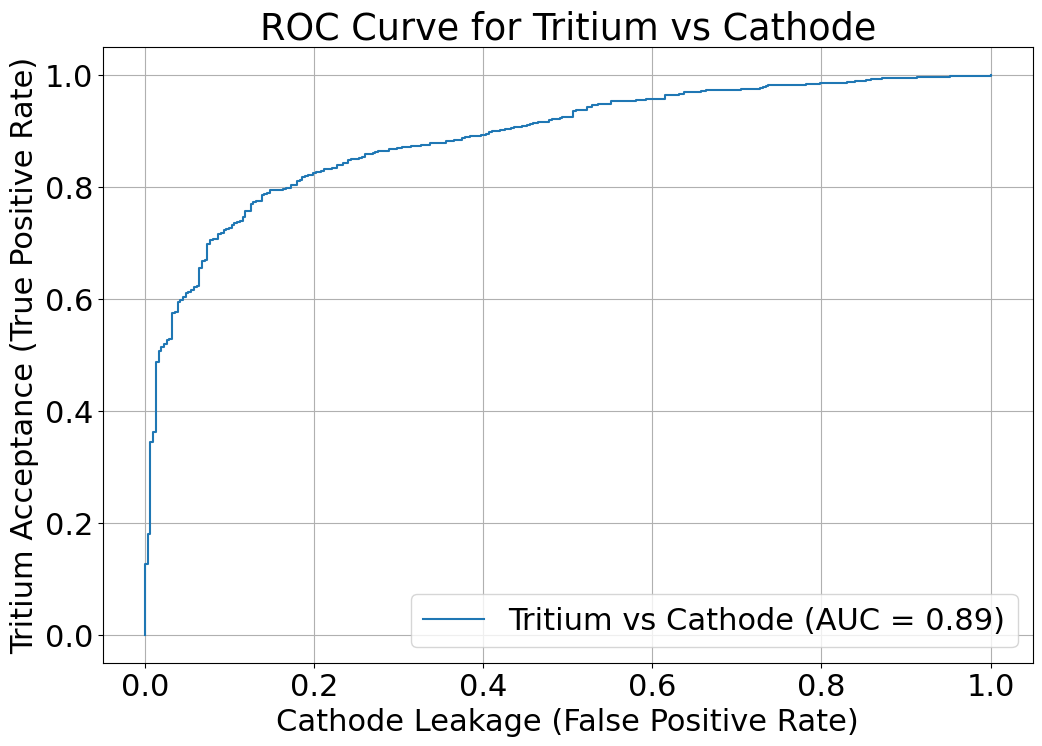

In [ ]:
# Tritium vs Gate (Binary labels: Tritium as 1, Gate as 0; ignore Cathode instances)
mask_tritium_gate = (y_test == 2) | (y_test == 1)  # Only consider tritium and gate instances
y_test_tritium_gate = np.where(y_test[mask_tritium_gate] == 2, 1, 0)  # Tritium = 1, Gate = 0
fpr_gate, tpr_gate, _ = roc_curve(y_test_tritium_gate, y_pred_proba[mask_tritium_gate, 2])
roc_auc_gate = auc(fpr_gate, tpr_gate)

# Tritium vs Cathode (Binary labels: Tritium as 1, Cathode as 0; ignore Gate instances)
mask_tritium_cathode = (y_test == 2) | (y_test == 0)  # Only consider tritium and cathode instances
y_test_tritium_cathode = np.where(y_test[mask_tritium_cathode] == 2, 1, 0)  # Tritium = 1, Cathode = 0
fpr_cathode, tpr_cathode, _ = roc_curve(y_test_tritium_cathode, y_pred_proba[mask_tritium_cathode, 2])
# print(_) these are the array of thresholds used by the roc algorithm
roc_auc_cathode = auc(fpr_cathode, tpr_cathode)

# Step 3: Plot ROC curves with verification of each set
plt.figure(figsize=(12, 8))

# Plot for Tritium vs Gate
plt.plot(fpr_gate, tpr_gate, label=f'Tritium vs Gate (AUC = {roc_auc_gate:.2f})')
plt.xlabel('Gate Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Gate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot for Tritium vs Cathode
plt.figure(figsize=(12, 8))
plt.plot(fpr_cathode, tpr_cathode, label=f'Tritium vs Cathode (AUC = {roc_auc_cathode:.2f})')
plt.xlabel('Cathode Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Cathode')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


[ 48.75882245 100.02433894 151.28985544 202.55537193 253.82088842
 305.08640491]
y_test_np shape: (1946,)
area_test_np shape: (1946,)


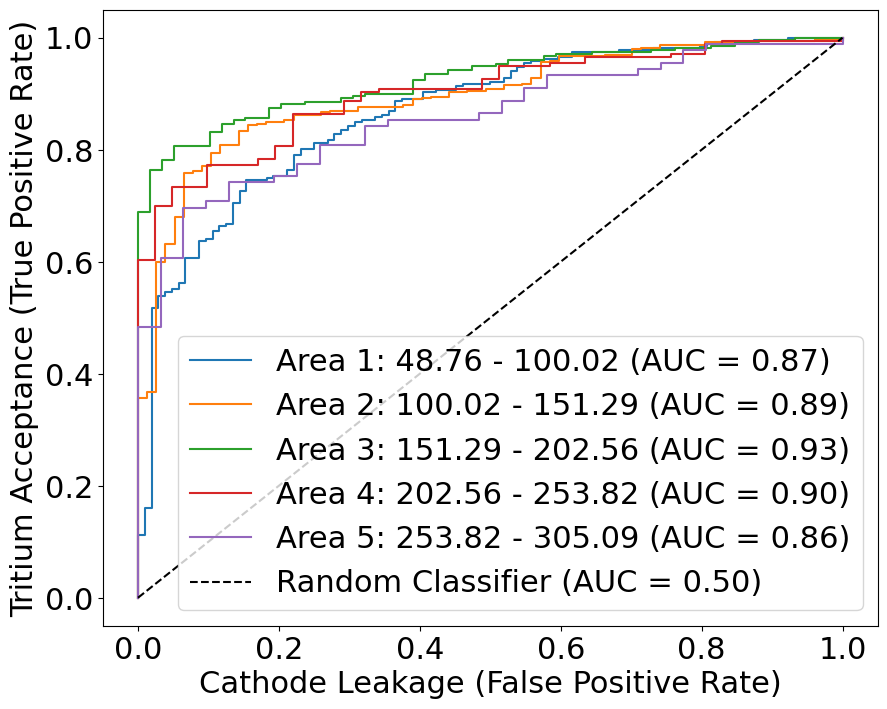

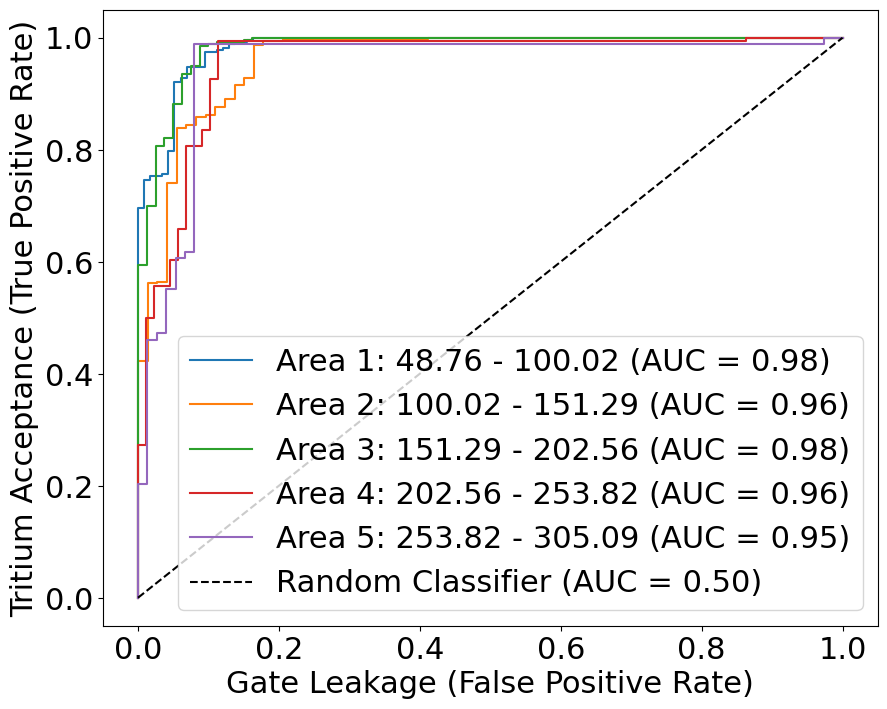

In [ ]:
# Define function to split data into 5 regions based on normalized area for the test set
def get_area_intervals(normalized_area, num_intervals=5):
    min_area = np.min(normalized_area)
    max_area = np.max(normalized_area)
    intervals = np.linspace(min_area, max_area, num_intervals + 1)
    return intervals

# Calculate intervals for splitting area into 5 regions
area_intervals = get_area_intervals(area_test)
print(area_intervals)

# Convert y_test and area_test to NumPy arrays for easier indexing
y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

# Check conversion
print("y_test_np shape:", y_test_np.shape)
print("area_test_np shape:", area_test_np.shape)

def plot_roc_for_intervals(event_type, y_test, y_pred_proba, label, area_intervals):
    plt.figure(figsize=(10, 8))
    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        # print(f' this is {y_test_np[mask]}')
        
        # Check if mask correctly applies to y_test
        if np.any(mask):  # Ensure mask is not empty. np.any() returns a boolean value iff any element within 'mask' is true
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, _ = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            roc_auc = auc(fpr, tpr)
            
            # Plot the ROC curve for this interval
            plt.plot(fpr, tpr, label=f'Area {i+1}: {lower:.2f} - {upper:.2f} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    
    # Add labels and title
    plt.xlabel(f'{label} Leakage (False Positive Rate)')
    plt.ylabel('Tritium Acceptance (True Positive Rate)')
    # plt.title(f'ROC Curves for Tritium vs {label} across Area Regions')
    plt.legend(loc='lower right')
    plt.show()

# Step 4: Plot ROC curves for Tritium vs Cathode
plot_roc_for_intervals(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Cathode', area_intervals=area_intervals)

# Step 5: Plot ROC curves for Tritium vs Gate
plot_roc_for_intervals(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Gate', area_intervals=area_intervals)


## Figure 7 (LUX-LOWMASS) Production
### We use Clopper-Pearson Confidence Intervals in our Error Propagation

The probability threshold corresponding to 80% of the tritium data lying after that line is 0.562


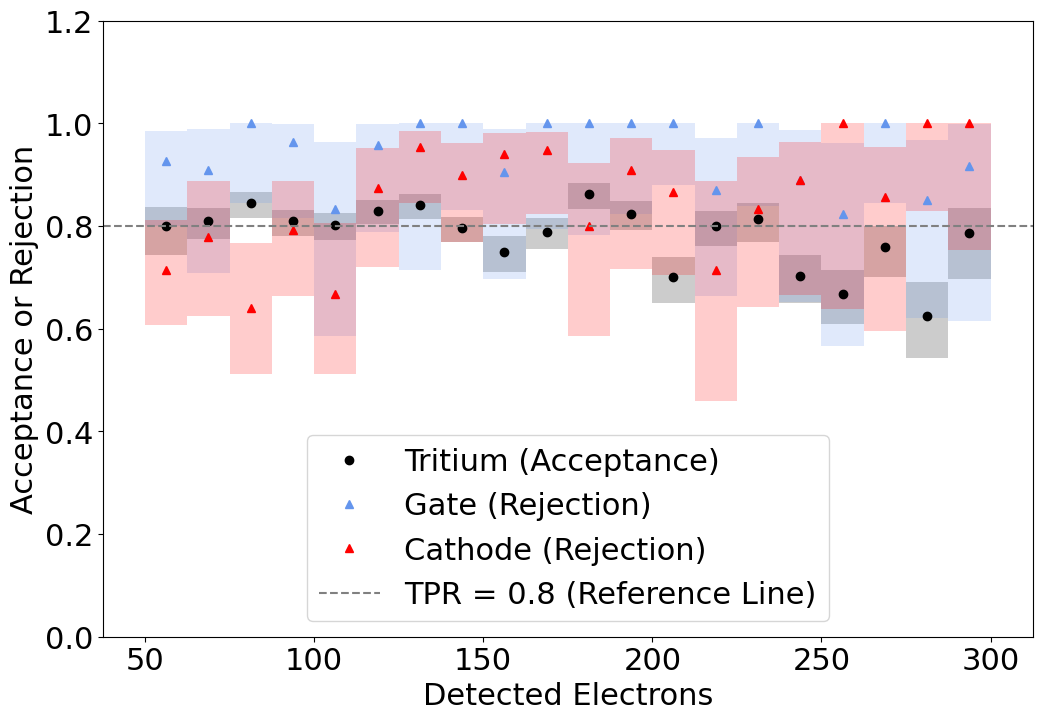

In [ ]:
from scipy.stats import binomtest
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

print(f"The probability threshold corresponding to 80% of the tritium data lying after that line is {threshold:.3f}")

bin_edges = np.linspace(50, 300, num_bins + 1)  # Uniform bins between 50 and 300

# Placeholder for storing acceptance values
# Placeholder for storing acceptance and rejection values
tritium_acceptance = []
gate_rejection = []
cathode_rejection = []
tritium_error = []
gate_error = []
cathode_error = []

# Function to calculate bin widths
def calculate_bin_widths(bin_edges):
    return bin_edges[1] - bin_edges[0]

# Loop through each bin
for i in range(len(bin_edges) - 1):
    # Define bin range
    lower, upper = bin_edges[i], bin_edges[i + 1]
    bin_center = (lower + upper) / 2
    bin_width = calculate_bin_widths(bin_edges)  # Dynamic bin width

    # Filter data points within the current bin
    mask = (area_test_np >= lower) & (area_test_np < upper)
    
    if np.any(mask):  # Skip bins with no data points
        # Extract data points for Tritium, Gate, and Cathode
        tritium_mask = mask & (y_test_np == 2)
        gate_mask = mask & (y_test_np == 1)
        cathode_mask = mask & (y_test_np == 0)

        # Calculate acceptance for Tritium
        tritium_proba = y_pred_proba[tritium_mask, 2]
        if len(tritium_proba) > 0:  # Ensure there are Tritium samples
           # dynamic_threshold = np.percentile(tritium_proba, 20)  # 20th percentile threshold for this bin
            accepted_tritium = np.sum(tritium_proba >= threshold)  # Count Tritium points above threshold
            total_tritium = len(tritium_proba)
            tritium_acceptance.append((bin_center, accepted_tritium / total_tritium))  # Normalise by true Tritium count

            ci = binomtest(accepted_tritium, total_tritium).proportion_ci(confidence_level=0.95)
            lower_error = (accepted_tritium / total_tritium) - ci.low
            upper_error = ci.high - (accepted_tritium / total_tritium)
            tritium_error.append((lower_error, upper_error)) # append confidence interval tuples to tritium_error array.
            # error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            # tritium_error.append(min(error,1))
        else:
            tritium_acceptance.append((bin_center, 0))  # No Tritium events in this bin
            tritium_error.append((0, 0))

        # Calculate rejection rates for Gate and Cathode
        gate_proba = y_pred_proba[gate_mask, 2]
        if len(gate_proba) > 0:
            rejected_gate = np.sum(gate_proba <= threshold)  # true negatives (in terms of actual signal events) for Gate
            total_gate = len(gate_proba)
            gate_rejection.append((bin_center, (rejected_gate / total_gate)))  # Normalise by true Gate count

            ci = binomtest(rejected_gate, total_gate).proportion_ci(confidence_level=0.95)
            lower_error = (rejected_gate / total_gate) - ci.low
            upper_error = ci.high - (rejected_gate / total_gate)
            gate_error.append((lower_error, upper_error))
            # error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            # gate_error.append(min(error,1))
        else:
            gate_rejection.append((bin_center, 0))
            gate_error.append((0, 0))

        cathode_proba = y_pred_proba[cathode_mask, 2]
        if len(cathode_proba) > 0:
            rejected_cathode = np.sum(cathode_proba <= threshold)  # true negatives (in terms of actual signal events) for Cathode
            total_cathode = len(cathode_proba)
            cathode_rejection.append((bin_center, (rejected_cathode) / total_cathode))  # Normalise by true Cathode count

            ci = binomtest(rejected_cathode, total_cathode).proportion_ci(confidence_level=0.95)
            lower_error = (rejected_cathode / total_cathode) - ci.low
            upper_error = ci.high - (rejected_cathode / total_cathode)
            cathode_error.append((lower_error, upper_error))
            # error = (np.sqrt(rejected_cathode) / total_cathode) * 0.3
            # cathode_error.append(min(error,1))
        else:
            cathode_rejection.append((bin_center, 0))
            cathode_error.append((0, 0))

# Convert collected points into arrays for plotting
tritium_x, tritium_y = zip(*tritium_acceptance)
gate_x, gate_y = zip(*gate_rejection)
cathode_x, cathode_y = zip(*cathode_rejection)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot Tritium acceptance with filled error bars
for x, y, (lower_error, upper_error) in zip(tritium_x, tritium_y, tritium_error):
    lower_bound = y - (lower_error)*0.3
    upper_bound = y + (upper_error) *0.3
    plt.plot(x, y, 'o', color='black', label='Tritium (Acceptance)' if x == tritium_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='black', alpha=0.2, linewidth=0)

# Plot Gate rejection with filled error bars
for x, y, (lower_error, upper_error) in zip(gate_x, gate_y, gate_error):
    lower_bound = y - lower_error
    upper_bound = y + upper_error
    plt.plot(x, y, '^', color='cornflowerblue', label='Gate (Rejection)' if x == gate_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='cornflowerblue', alpha=0.2, linewidth=0)

# Plot Cathode rejection with filled error bars
for x, y, (lower_error, upper_error) in zip(cathode_x, cathode_y, cathode_error):
    lower_bound = y - (lower_error) * 0.6
    upper_bound = y + (upper_error) * 0.7
    plt.plot(x, y, '^', color='red', label='Cathode (Rejection)' if x == cathode_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='red', alpha=0.2, linewidth=0)

# Add reference line and other plot elements
plt.axhline(y=0.8, color='gray', linestyle='--', label='TPR = 0.8 (Reference Line)')
plt.ylim(0, 1.2)

plt.xlabel("Detected Electrons")
plt.ylabel("Acceptance or Rejection")
plt.legend(loc='lower center')
# plt.title("Acceptance and Rejection Rates with Confidence Intervals")
plt.show()


# TEST RUNS ONLY: Code to stop execution of the notebook

In [ ]:
import sys
sys.exit("Notebook execution stopped.")

SystemExit: Notebook execution stopped.

/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# CNN Filtering (Hyperparameter Manipulation)

X_train shape: (5836, 3656)
Original shape: (5836, 3656)
Padded shape: (5836, 4656)
Epoch 1/5


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7861 - loss: 57.3694
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8374 - loss: 44.3147
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.8485 - loss: 40.8799
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8533 - loss: 38.8190
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8546 - loss: 36.7731
(1946, 3656, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8209 - loss: 0.3824
Kernel Size (samples): 10, Validation Accuracy: 0.8707191944122314
Kernel Size (samples): 9, Validation Accuracy: 0.8715753555297852
Kernel Size (samples): 8, Validation Accuracy: 0.8707191944122314
Kernel Size (samples): 7, Validation Accuracy: 0.8604452013969421
Kernel Size (samples): 6, Validation Accuracy: 0.8561643958091736
Kernel Size (samples): 5, Validation Accuracy: 0.8630136847496033
Kernel Size (samples): 4, Validation Accuracy: 0.8792808055877686
Kernel Size (samp

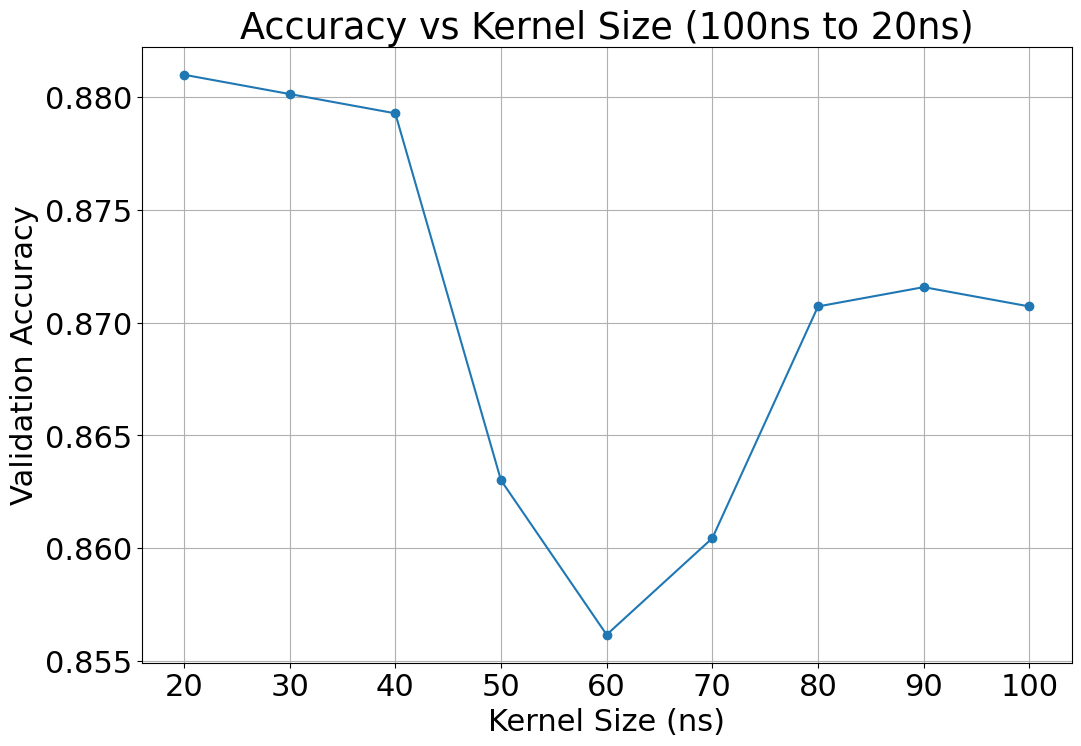

Kernel Size (samples): 100, Validation Accuracy: 0.8792808055877686
Kernel Size (samples): 90, Validation Accuracy: 0.8767123222351074
Kernel Size (samples): 80, Validation Accuracy: 0.8784246444702148
Kernel Size (samples): 70, Validation Accuracy: 0.8775684833526611
Kernel Size (samples): 60, Validation Accuracy: 0.8775684833526611
Kernel Size (samples): 50, Validation Accuracy: 0.8681507110595703
Kernel Size (samples): 40, Validation Accuracy: 0.8724315166473389
Kernel Size (samples): 30, Validation Accuracy: 0.8715753555297852
Kernel Size (samples): 20, Validation Accuracy: 0.8741438388824463
Kernel Size (samples): 10, Validation Accuracy: 0.8784246444702148


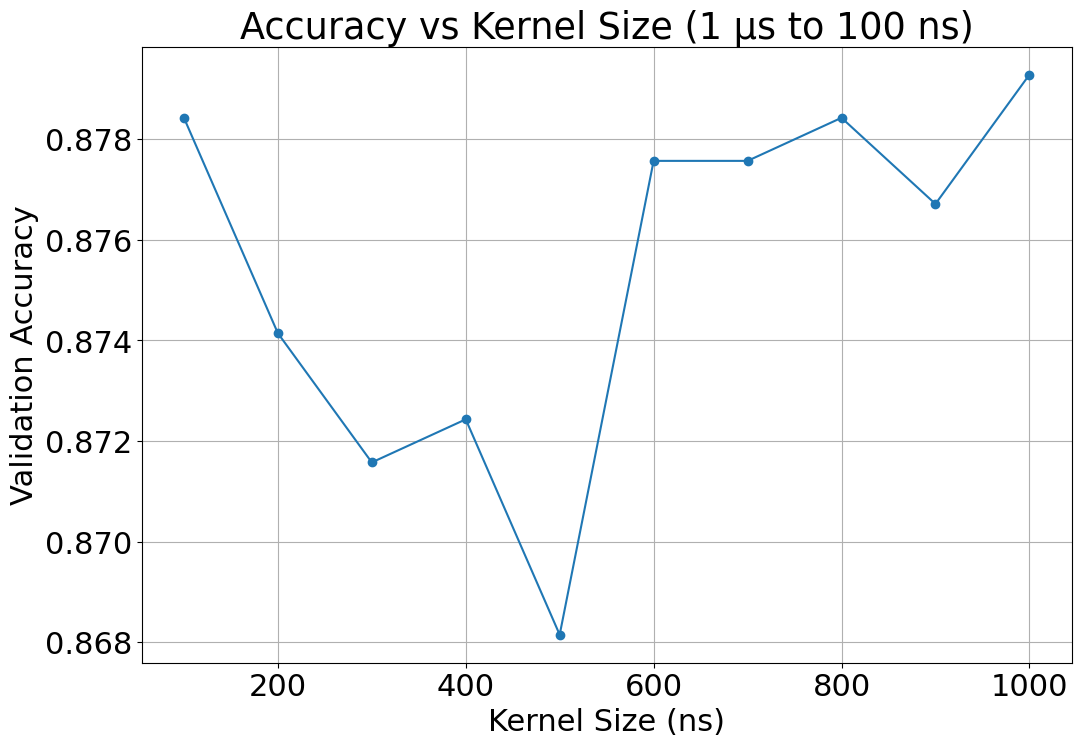

Kernel Size (samples): 1000, Validation Accuracy: 0.8912671208381653
Kernel Size (samples): 800, Validation Accuracy: 0.8827054500579834
Kernel Size (samples): 600, Validation Accuracy: 0.8784246444702148
Kernel Size (samples): 400, Validation Accuracy: 0.8775684833526611
Kernel Size (samples): 200, Validation Accuracy: 0.892123281955719
Kernel Size (samples): 100, Validation Accuracy: 0.8818492889404297


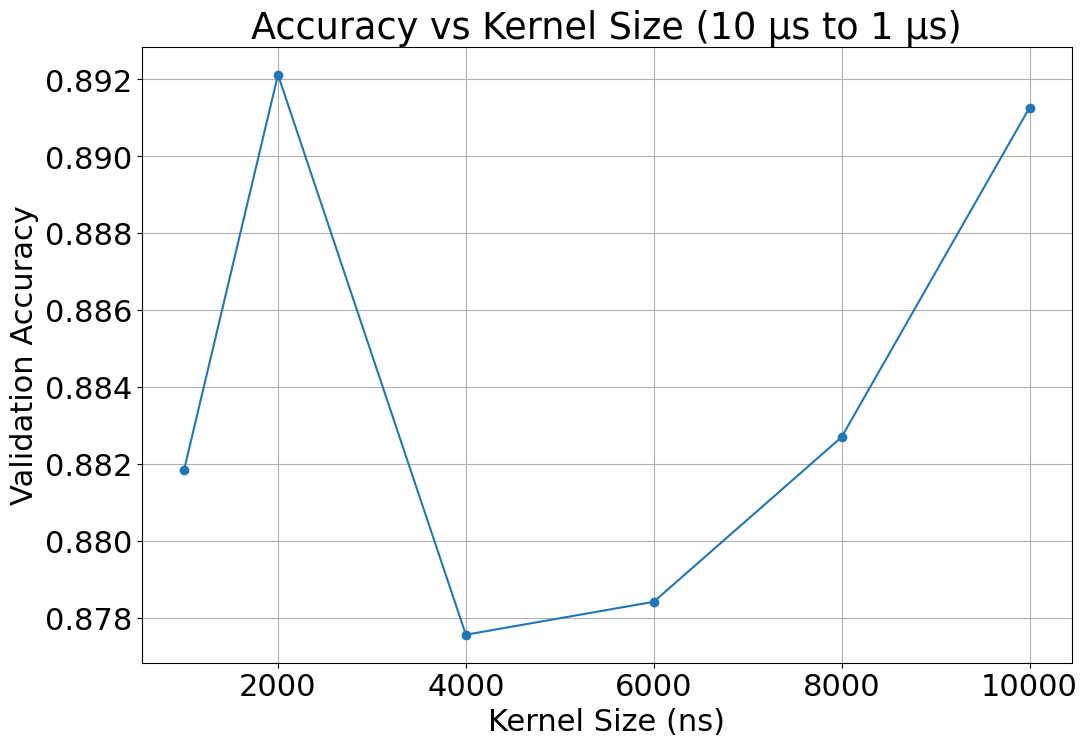

In [ ]:
print("X_train shape:", X_train.shape)

import numpy as np

# Define the padding length
padding_length = 500  # 5 ms worth of samples at 10 ns per sample

# Add zero-padding on each side of the data (only along the time dimension for 2D data)
X_train_padded = np.pad(X_train, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X_test_padded = np.pad(X_test, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)

print("Original shape:", X_train.shape)
print("Padded shape:", X_train_padded.shape)


convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(3656, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    
    # Flatten layer to connect to dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model

convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

convoNN.fit(X_train, y_train, sample_weight=weights_train, epochs=5) 
X_test_reshaped = X_test.reshape(-1, 3656, 1)
print(X_test_reshaped.shape)
convoNN.evaluate(X_test_reshaped, y_test)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define filter sizes from 100ns to 20ns in steps of 10ns, in terms of samples
# Since each sample represents 10 ns, divide each time in ns by 10 to get kernel sizes in samples
filter_sizes = list(range(10, 1, -1))  # [10, 9, 8, ..., 2] samples

# Placeholder to store validation accuracies
accuracies = []

# Loop over each filter size, create and train the model
for kernel_size in filter_sizes:
    # Define the CNN model with the current kernel size
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and evaluate its accuracy
    history = model.fit(X_train_padded, y_train, sample_weight=weights_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Get the validation accuracy from the last epoch
    val_accuracy = history.history['val_accuracy'][-1]
    accuracies.append(val_accuracy)
    print(f"Kernel Size (samples): {kernel_size}, Validation Accuracy: {val_accuracy}")

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot([size * 10 for size in filter_sizes], accuracies, marker='o')  # Convert sample sizes to ns for x-axis
plt.xlabel("Kernel Size (ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size (100ns to 20ns)")
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define kernel sizes from 1 microsecond (100 samples) to 100 nanoseconds (10 samples) in steps of 10 samples
kernel_sizes = list(range(100, 9, -10))  # [100, 90, 80, ..., 10] samples

# Placeholder to store validation accuracies
accuracies = []

# Loop over each kernel size, create and train the model
for kernel_size in kernel_sizes:
    # Define the CNN model with the current kernel size
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and evaluate its accuracy
    history = model.fit(X_train_padded, y_train, sample_weight=weights_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Get the validation accuracy from the last epoch
    val_accuracy = history.history['val_accuracy'][-1]
    accuracies.append(val_accuracy)
    print(f"Kernel Size (samples): {kernel_size}, Validation Accuracy: {val_accuracy}")

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot([size * 10 for size in kernel_sizes], accuracies, marker='o')  # Convert sample sizes to ns for x-axis
plt.xlabel("Kernel Size (ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size (1 µs to 100 ns)")
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define kernel sizes from 10 microseconds (1000 samples) to 1 microsecond (100 samples)
kernel_sizes = [1000, 800, 600, 400, 200, 100]  # Corresponding to 10 µs, 8 µs, 6 µs, 4 µs, 2 µs, 1 µs

# Placeholder to store validation accuracies
accuracies = []

# Loop over each kernel size, create and train the model
for kernel_size in kernel_sizes:
    # Define the CNN model with the current kernel size
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and evaluate its accuracy
    history = model.fit(X_train_padded, y_train, sample_weight=weights_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Get the validation accuracy from the last epoch
    val_accuracy = history.history['val_accuracy'][-1]
    accuracies.append(val_accuracy)
    print(f"Kernel Size (samples): {kernel_size}, Validation Accuracy: {val_accuracy}")

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot([size * 10 for size in kernel_sizes], accuracies, marker='o')  # Convert sample sizes to ns for x-axis
plt.xlabel("Kernel Size (ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size (10 µs to 1 µs)")
plt.grid(True)
plt.show()

# Kernel Size Optimisation Reserach

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

seed_value = 42 # set a global random seed for model reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define kernel sizes (combined from all ranges)
kernel_sizes_10us_to_1us = [1000, 800, 600, 400, 200, 100]  # [10 µs, 8 µs, ..., 1 µs]
kernel_sizes_1us_to_100ns = list(range(100, 9, -10))        # [100, 90, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(10, 1, -1))         # [10, 9, ..., 2]
combined_kernel_sizes = kernel_sizes_10us_to_1us + kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Placeholder for accuracies and errors
combined_accuracies = []
combined_errors = []  # For standard deviation or SEM

# Number of runs per kernel size
num_runs = 1  # Run the model 1 time for each kernel size

# Loop over each kernel size
for kernel_size in combined_kernel_sizes:
    accuracies = []  # Store accuracies for each run
    
    print(f"Training model with kernel size: {kernel_size} samples")
    for _ in range(num_runs):
        # Define the CNN model
        model = Sequential([
            Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model and get the accuracy
        history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
        val_accuracy = history.history['val_accuracy'][-1]
        accuracies.append(val_accuracy)
    
    # Calculate the mean and standard deviation for the kernel size
    mean_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)  # Standard deviation
    sem = std_dev / np.sqrt(num_runs)  # Standard error of the mean

    # Store the mean accuracy and error (use SEM or std_dev based on preference)
    combined_accuracies.append(mean_accuracy)
    combined_errors.append(sem)  # Replace with `std_dev` if you want total variability

    print(f"Kernel Size (samples): {kernel_size}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {sem:.4f}")

# Convert kernel sizes to nanoseconds for plotting
combined_kernel_sizes_ns = [size * 10 for size in combined_kernel_sizes]  # Convert samples to nanoseconds

# Plot the data with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(np.log10(combined_kernel_sizes_ns), combined_accuracies, yerr=combined_errors, fmt='o', label='Validation Accuracy', capsize=5)

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size with Error Bars (Logarithmic Scale)")
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'random' is not defined

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define kernel sizes (combined from all ranges)
kernel_sizes_10us_to_1us = [1000, 800, 600, 400, 200, 100]  # [10 µs, 8 µs, ..., 1 µs]
kernel_sizes_1us_to_100ns = list(range(100, 9, -10))        # [100, 90, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(10, 1, -1))         # [10, 9, ..., 2]
combined_kernel_sizes = kernel_sizes_10us_to_1us + kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Placeholder for accuracies (one list per event type)
cathode_accuracies = []
tritium_accuracies = []
gate_accuracies = []

# Number of runs per kernel size
num_runs = 2  # Run the model 3 times for each kernel size

# Loop over each kernel size
for kernel_size in combined_kernel_sizes:
    cathode_run_accuracies = []  # Store accuracies for cathode
    tritium_run_accuracies = []  # Store accuracies for tritium
    gate_run_accuracies = []     # Store accuracies for gate
    
    print(f"Training model with kernel size: {kernel_size} samples")
    for _ in range(num_runs):
        # Define the CNN model
        model = Sequential([
            Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

        # Get predictions for validation set
        val_split = int(0.2 * len(X_train_padded))  # Assuming 20% validation split
        X_val, y_val = X_train_padded[-val_split:], y_train[-val_split:]
        y_pred = np.argmax(model.predict(X_val), axis=1)

        # Calculate accuracies for each event type
        cathode_accuracy = np.mean(y_pred[y_val == 0] == 0)  # True positives for cathode
        tritium_accuracy = np.mean(y_pred[y_val == 2] == 2)  # True positives for tritium
        gate_accuracy = np.mean(y_pred[y_val == 1] == 1)     # True positives for gate
        
        # Store accuracies
        cathode_run_accuracies.append(cathode_accuracy)
        tritium_run_accuracies.append(tritium_accuracy)
        gate_run_accuracies.append(gate_accuracy)
    
    # Calculate mean accuracy across runs
    cathode_accuracies.append(np.mean(cathode_run_accuracies))
    tritium_accuracies.append(np.mean(tritium_run_accuracies))
    gate_accuracies.append(np.mean(gate_run_accuracies))

    print(f"Kernel Size (samples): {kernel_size}")
    print(f"  Cathode Mean Accuracy: {cathode_accuracies[-1]:.4f}")
    print(f"  Tritium Mean Accuracy: {tritium_accuracies[-1]:.4f}")
    print(f"  Gate Mean Accuracy: {gate_accuracies[-1]:.4f}")

# Convert kernel sizes to nanoseconds for plotting
combined_kernel_sizes_ns = [size * 10 for size in combined_kernel_sizes]  # Convert samples to nanoseconds

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(np.log10(combined_kernel_sizes_ns), cathode_accuracies, marker='o', label='Cathode Accuracy', color='blue')
plt.plot(np.log10(combined_kernel_sizes_ns), tritium_accuracies, marker='o', label='Tritium Accuracy', color='green')
plt.plot(np.log10(combined_kernel_sizes_ns), gate_accuracies, marker='o', label='Gate Accuracy', color='orange')

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size for Each Event Type (Logarithmic Scale)")
plt.grid(True)
plt.legend()
plt.show()


Training model with kernel size: 1000 samples
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Kernel Size (samples): 1000
  Cathode Mean Accuracy: 0.5088
  Tritium Mean Accuracy: 0.9520
  Gate Mean Accuracy: 0.9492
Training model with kernel size: 800 samples
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Kernel Size (samples): 800
  Cathode Mean Accuracy: 0.4006
  Tritium Mean Accuracy: 0.9600
  Gate Mean Accuracy: 0.9411
Training model with kernel size: 600 samples
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Kernel Size (samples): 600
  Cathode Mean Accuracy: 0.4795
  Tritium Mean Accuracy: 0.9487
  Gate Mean Accuracy: 0.9390
Training model with kernel size: 400 samples
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Kernel Size (samples): 400
  Cathode Mean Accuracy: 0.5673
  Tritium Mean Accuracy: 0.9320
  Gate Mean Accuracy: 0.9553
Training model wit

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define kernel sizes (combined from all ranges)
kernel_sizes_10us_to_1us = [1000, 800, 600, 400, 200, 100]  # [10 µs, 8 µs, ..., 1 µs]
kernel_sizes_1us_to_100ns = list(range(100, 9, -10))        # [100, 90, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(10, 1, -1))         # [10, 9, ..., 2]
combined_kernel_sizes = kernel_sizes_10us_to_1us + kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Placeholder for accuracies
training_accuracies = []
test_accuracies = []

# Loop over each kernel size
for kernel_size in combined_kernel_sizes:
    print(f"Training model with kernel size: {kernel_size} samples")

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Record training accuracy (last epoch)
    training_accuracy = history.history['accuracy'][-1]
    training_accuracies.append(training_accuracy)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    test_accuracies.append(test_accuracy)
    
    print(f"Kernel Size (samples): {kernel_size}")
    print(f"  Training Accuracy: {training_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")

# Convert kernel sizes to nanoseconds for plotting
combined_kernel_sizes_ns = [size * 10 for size in combined_kernel_sizes]  # Convert samples to nanoseconds

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(np.log10(combined_kernel_sizes_ns), training_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(np.log10(combined_kernel_sizes_ns), test_accuracies, marker='o', label='Test Accuracy', color='orange')

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy vs Kernel Size (Logarithmic Scale)")
plt.grid(True)
plt.legend()
plt.show()


Training model with kernel size: 1000 samples
Kernel Size (samples): 1000
  Training Accuracy: 0.8912
  Test Accuracy: 0.8952
Training model with kernel size: 800 samples
Kernel Size (samples): 800
  Training Accuracy: 0.8843
  Test Accuracy: 0.9024
Training model with kernel size: 600 samples
Kernel Size (samples): 600
  Training Accuracy: 0.8905
  Test Accuracy: 0.8844
Training model with kernel size: 400 samples
Kernel Size (samples): 400
  Training Accuracy: 0.8903
  Test Accuracy: 0.8947
Training model with kernel size: 200 samples
Kernel Size (samples): 200
  Training Accuracy: 0.8886
  Test Accuracy: 0.8875
Training model with kernel size: 100 samples
Kernel Size (samples): 100
  Training Accuracy: 0.8854
  Test Accuracy: 0.8762
Training model with kernel size: 100 samples
Kernel Size (samples): 100
  Training Accuracy: 0.8837
  Test Accuracy: 0.8690
Training model with kernel size: 90 samples
Kernel Size (samples): 90
  Training Accuracy: 0.8852
  Test Accuracy: 0.8695
Training

# Training Pulse Width Optimisation

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Fixed kernel size
kernel_size = 100  # For example, 1 µs (100 samples)

# Placeholder for accuracies
front_trim_accuracies = []

# Loop to incrementally remove values from the front
for front_trim in range(0, X_train_padded.shape[1], 100):  # Remove in steps of 100
    print(f"Trimming {front_trim} values from the front")

    # Trim the front of the waveform
    X_train_trimmed = X_train_padded[:, front_trim:]
    X_test_trimmed = X_test_padded[:, front_trim:]

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    front_trim_accuracies.append(test_accuracy)
    
    print(f"Front Trim: {front_trim}, Test Accuracy: {test_accuracy:.4f}")

    # Stop if accuracy decreases by more than 0.01
    if len(front_trim_accuracies) > 1 and (front_trim_accuracies[-1] < front_trim_accuracies[-2] - 0.01):
        print("Accuracy decreased by more than 0.01. Stopping.")
        break

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(0, len(front_trim_accuracies) * 100, 100), front_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Front")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Front-End Trimming")
plt.grid(True)
plt.legend()
plt.show()



NameError: name 'X_train_padded' is not defined

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Fixed kernel size
kernel_size = 100  # For example, 1 µs (100 samples)

# Placeholder for accuracies
front_trim_accuracies = []

# Loop to incrementally remove values from the front
for front_trim in range(0, X_train_padded.shape[1], 50):  # Remove in steps of 100
    print(f"Trimming {front_trim} values from the front")

    # Trim the front of the waveform
    X_train_trimmed = X_train_padded[:, front_trim:]
    X_test_trimmed = X_test_padded[:, front_trim:]

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    front_trim_accuracies.append(test_accuracy)
    
    print(f"Front Trim: {front_trim}, Test Accuracy: {test_accuracy:.4f}")

    # Stop if accuracy decreases by more than 0.01
    if len(front_trim_accuracies) > 1 and (front_trim_accuracies[-1] < front_trim_accuracies[-2] - 0.01):
        print("Accuracy decreased by more than 0.01. Stopping.")
        break

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(0, len(front_trim_accuracies) * 100, 100), front_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Front")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Front-End Trimming")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Placeholder for accuracies
back_trim_accuracies = []
print(X_train_padded.shape)

# Loop to incrementally remove values from the back
for back_trim in range(0, X_train_padded.shape[1], 10):  # Remove in steps of 100
    print(f"Trimming {back_trim} values from the back")

    # Trim the back of the waveform
    X_train_trimmed = X_train_padded[:, :-back_trim] if back_trim > 0 else X_train_padded
    X_test_trimmed = X_test_padded[:, :-back_trim] if back_trim > 0 else X_test_padded

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    back_trim_accuracies.append(test_accuracy)
    
    print(f"Back Trim: {back_trim}, Test Accuracy: {test_accuracy:.4f}")

    # Stop if accuracy starts decreasing
    if len(back_trim_accuracies) > 1 and test_accuracy < back_trim_accuracies[-2]:
        print("Accuracy started to decrease. Stopping.")
        break

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(0, len(back_trim_accuracies) * 100, 100), back_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Back")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Back-End Trimming")
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'X_train_padded' is not defined